In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from preprocessing import market_prepro
import time
import pickle
import shap
# from multiprocessing import Pool
from auto_shap.auto_shap import generate_shap_values as gsv

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                            )

C:\Users\alexander\anaconda3\envs\itcs-8156\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now that we have Spencer's data importer lets make a driver that pulls in the data and training the model

SUDO CODE:

1. call data importer

2. restructure the dataset based on number of days desired [function written]

3. train model with training data

4. test model

5. return metrics

In [2]:
# st = "Stocks"
st = "ETFs"

#Input stock name
sn = "aadr" 
# f = r'D:\Desktop\College Spring 2023\machineLearning\project\coding\data'
f = r'H:\My Drive\stockMarket_data'
X_train, X_test, T_train, T_test = market_prepro(f,st,sn)

print(X_train.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1044 entries, 2010-07-21 to 2015-09-14
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              1044 non-null   float64
 1   High              1044 non-null   float64
 2   Low               1044 non-null   float64
 3   Volume            1044 non-null   float64
 4   High-Low          1044 non-null   float64
 5   Close-Open        1044 non-null   float64
 6   Day_date          1044 non-null   int32  
 7   Month             1044 non-null   int32  
 8   Year              1044 non-null   int32  
 9   near_end_quarter  1044 non-null   int64  
 10  Day               1044 non-null   int64  
dtypes: float64(6), int32(3), int64(2)
memory usage: 85.6 KB
None


In [3]:
def structure_timeseries_features(df,offset_back, offset_for,exclude):
    '''
    This takes a dataframe and creates new columns that contain the data from
    previous days so that time series forecasting can occur.

    INPUTS:
        df - dataframe: input data

        offset - int: the number of days to go back. This creates this many
                        new columns

        exclude - list str: list of columns to exclude from the time series 
                            expansion

    OUTPUTS:
        df_out - dataframe: dataframe with new columns
    '''

    df_out = pd.DataFrame() 

    for cc in df.columns.values:
        if (cc not in exclude):
            for ii in range(offset_back):
                col_name = (cc+"_m"+str(ii+1))

                df_out[col_name] = df[cc].shift(ii+1)


    df_out = df_out.iloc[offset_back:-offset_for,:]

    return df_out

def structure_timeseries_targets(df,offset_back, offset_for):
    '''
    companion function to remove the first few days of targets to make sure
    the sizes match between features and targets.

    INPUTS:
        df - dataframe: input data targets.

    OUTPUTS:
        df_out - dataframe: dataframe with rows removed

    '''
    # df_out = df.iloc[offset:]

    df_out = pd.DataFrame() 

    # for cc in df.columns.values:
    for ii in range(offset_for):
        col_name = (df.name+"_p"+str(ii))

        df_out[col_name] = df.shift(-(ii))


    df_out = df_out.iloc[offset_back:-offset_for,:]

    return df_out

# ff = X_train.copy()
# tt = T_train.copy()



# df_ff = structure_timeseries_features(ff,2,5, ['Day_date','Month','Year'])
# df_tt = structure_timeseries_targets(tt,2,5)


In [10]:
from sklearn.metrics import (r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                            )


def modeldriver(mdl, n_days_back, n_days_for, f, st, sn):
    '''
    This function takes a model, imports the data, trains the model, and tests 
    the model

    INPUTS:
        mdl -  the model to test

        n_days_back - int: the number of days to go back to use as features

        n_days_for - int: the number of days to predict into the future

        f - str: filepath to the stock

        st - str: stock type

        sn - str: stock name
    OUTPUTS:
        NONE:
    '''

    exclude_col = ['Day_date','Month','Year']

    X_train, X_test, T_train, T_test = market_prepro(f,st,sn)

    X_train = structure_timeseries_features(X_train,
                                            n_days_back, 
                                            n_days_for, 
                                            exclude_col,
                                            )
    X_test = structure_timeseries_features(X_test,
                                           n_days_back, 
                                           n_days_for, 
                                           exclude_col,
                                           )
    T_train =  structure_timeseries_targets(T_train,
                                            n_days_back,
                                            n_days_for,
                                            )
    T_test =  structure_timeseries_targets(T_test,
                                            n_days_back,
                                            n_days_for,
                                            )
    
    print(X_train.shape,X_test.shape)
    data = {'X_train': X_train, 
            'X_test': X_test, 
            'T_train': T_train, 
            'T_test':T_test}
    

    mdl.fit(X_train,T_train)

    y_train = mdl.predict(X_train)
    y_test = mdl.predict(X_test)

    y_train = pd.DataFrame(y_train,
                           columns=T_train.columns.values,
                           index=T_train.index
                           )
    y_test = pd.DataFrame(y_test,
                          columns=T_test.columns.values,
                          index=T_test.index
                          )

    score_train = mdl.score(X_train,T_train)
    score_test = mdl.score(X_test,T_test)

    test_mape = mean_absolute_percentage_error(data['T_test'],y_test, multioutput='raw_values')

    print('Test MAPE(%) ', test_mape*100)

    return y_train, y_test, data

def modeldriverCV(mdl, n_days_back, n_days_for, f, st, sn, mdl_params,SVR=False):

    '''
    This function takes a model, imports the data, trains the model, and tests 
    the model

    INPUTS:
        mdl -  the model to test

        n_days_back - int: the number of days to go back to use as features

        n_days_for - int: the number of days to predict into the future

        f - str: filepath to the stock

        st - str: stock type

        sn - str: stock name
        
        mdl_params - paramaters to be used in grid search
    OUTPUTS:
        NONE:
    '''
    def shappening(mdl_type,mdl,X,verbose=True,plot=True):
        print(str(mdl_type))
        explainer = shap.Explainer(mdl.predict, X)
        
        if str(mdl_type) == 'SVR()':
            shap_values = explainer(shap.sample(X,100))
            # shap_values = gsv(mdl_shp, X, use_kernel=True, regression_model = True)
            if verbose == True:
                print(shap_values)
            if plot == True:
                shap.plots.waterfall(shap_values[0])
                
        if str(mdl_type) == 'Ridge()':
            shap_values = explainer(X)
            exp = shap.Explanation(shap_values.values, shap_values.base_values[0][0], shap_values.data)
            # shap_values, shap_expected_value, global_shap_df = gsv(mdl_shp, X)#, use_kernel=True, regression_model = True)
            # shap_values = Pool.map(explainer(X),8)
            if verbose == True:
                print(shap_values)
            if plot == True:
                shap.plots.waterfall(exp[3])   
        
        if str(mdl_type) == 'Lasso()':
            shap_values = explainer(X)
            # exp = shap.Explanation(shap_values.values, shap_values.base_values[0][0], shap_values.data)
            if verbose == True:
                print(shap_values)
            if plot == True:
                shap.plots.waterfall(shap_values[0]) 
                
        return shap_values
            
            
    start_time = time.time()
    exclude_col = ['Day_date','Month','Year']
    best_params={}
    best_scores={}
    best_model={}
    result={}
    dsets={}
    Xi, Ti = market_prepro(f,st,sn,verbose=False,splitdata=False)
    for jj in n_days_back:
        for kk in n_days_for:
            best=[]
            X = structure_timeseries_features(Xi,
                                                    jj, 
                                                    kk, 
                                                    exclude_col,
                                                    )

            T =  structure_timeseries_targets(Ti,
                                                    jj,
                                                    kk,
                                                    )


            if str(mdl) == 'SVR()':
                clm='Close_p'+f'{kk-1}'
                T = np.ravel(T[clm])
                
            data = {'X': X, 
                    'T':T}
            tscv = TimeSeriesSplit(n_splits = 5)
            mdl_cv = GridSearchCV(mdl, cv=tscv,
                                  scoring='neg_mean_absolute_percentage_error',
                                  param_grid=mdl_params,
                                  n_jobs=8)
            mdl_cv.fit(X,T)
            dsets[jj,kk]=X
            best_model[jj,kk]=mdl_cv.best_estimator_
            best_params[jj,kk]=mdl_cv.best_params_
            best_scores[jj,kk]=mdl_cv.best_score_*(-100)
            # print(best_scores[jj,kk])
            best.append(f'Best Model = {best_model[jj,kk]}')
            best.append(f'Training days back = {kk}, Prediction days forward = {jj}')
            best.append(best_params[jj,kk])
            best.append(f'MAPE = {best_scores[jj,kk]}')
            # print(best_scores)
            
            result[jj,kk]=best
            
        
        end_time = time.time()
        total_time= end_time-start_time
        print(f'Run time {total_time}s')

        mdl_shp=list(best_model.values())[np.argmin(list(best_scores))]
        x_shp=list(dsets.values())[np.argmin(list(best_scores))]
        shappening(mdl,mdl_shp,x_shp)
        
    return result 

def pickleBucket(sn, *results):
    '''
    sn = stockname
    *results = selected result arrays
    '''

    with open((f'{sn}'+'.pkl'), 'wb') as f:
        for result in results:
            pickle.dump(result, f)



Run time 10.63278865814209s
SVR()


Exact explainer: 101it [02:15,  1.44s/it]                                                                              


.values =
array([[-1.79056136e-02, -1.91505841e-02, -2.14306753e-02,
        -1.40769305e-02,  1.01089339e-04, -8.17563072e-01,
        -2.07554043e-03,  6.76362049e-03],
       [-7.34564394e-02, -7.48421796e-02, -6.57336872e-02,
        -1.34126352e-02, -2.53667092e-04, -2.19088233e+00,
        -2.11148861e-03, -1.02796953e-02],
       [ 7.98585619e-02,  7.32118250e-02,  6.57059119e-02,
        -1.76035310e-02,  1.72794810e-04,  1.94541328e+00,
        -2.00629643e-03,  2.74149602e-03],
       [ 2.58917630e-02,  2.11072008e-02,  2.19939320e-02,
        -1.39379488e-02, -7.17208412e-05,  7.66578092e-01,
        -2.04025438e-03,  6.18815820e-03],
       [ 5.26890300e-02,  5.71670675e-02,  5.40224054e-02,
        -1.68727942e-02,  3.13005438e-05,  2.01206603e+00,
        -2.01079395e-03, -6.08992462e-03],
       [ 2.99089109e-01,  3.10620282e-01,  2.79220976e-01,
         3.00724169e-02,  7.28117224e-04,  8.80873958e+00,
        -1.79428819e-03,  2.71634864e-03],
       [ 4.50593282e-02,

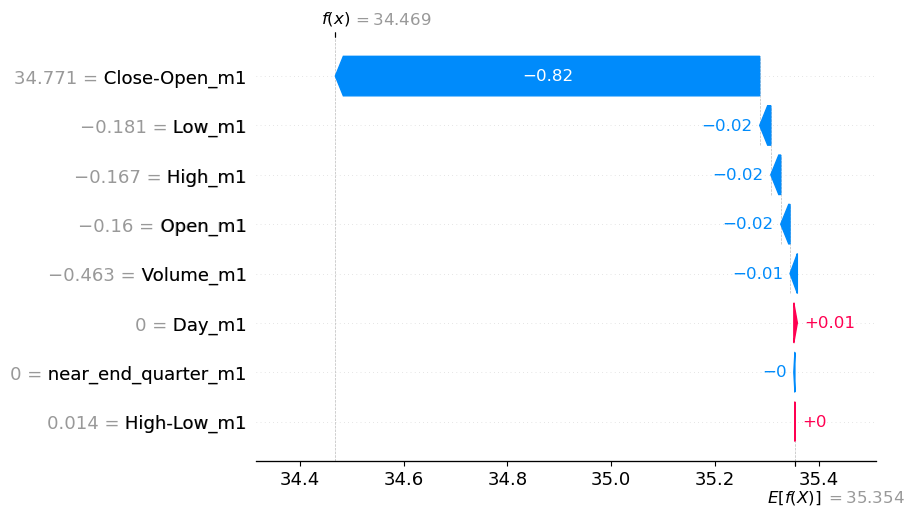

Run time 159.34212684631348s
SVR()


Exact explainer: 101it [02:17,  1.48s/it]                                                                              


.values =
array([[-1.79056136e-02, -1.91505841e-02, -2.14306753e-02,
        -1.40769305e-02,  1.01089339e-04, -8.17563072e-01,
        -2.07554043e-03,  6.76362049e-03],
       [-7.34564394e-02, -7.48421796e-02, -6.57336872e-02,
        -1.34126352e-02, -2.53667092e-04, -2.19088233e+00,
        -2.11148861e-03, -1.02796953e-02],
       [ 7.98585619e-02,  7.32118250e-02,  6.57059119e-02,
        -1.76035310e-02,  1.72794810e-04,  1.94541328e+00,
        -2.00629643e-03,  2.74149602e-03],
       [ 2.58917630e-02,  2.11072008e-02,  2.19939320e-02,
        -1.39379488e-02, -7.17208412e-05,  7.66578092e-01,
        -2.04025438e-03,  6.18815820e-03],
       [ 5.26890300e-02,  5.71670675e-02,  5.40224054e-02,
        -1.68727942e-02,  3.13005438e-05,  2.01206603e+00,
        -2.01079395e-03, -6.08992462e-03],
       [ 2.99089109e-01,  3.10620282e-01,  2.79220976e-01,
         3.00724169e-02,  7.28117224e-04,  8.80873958e+00,
        -1.79428819e-03,  2.71634864e-03],
       [ 4.50593282e-02,

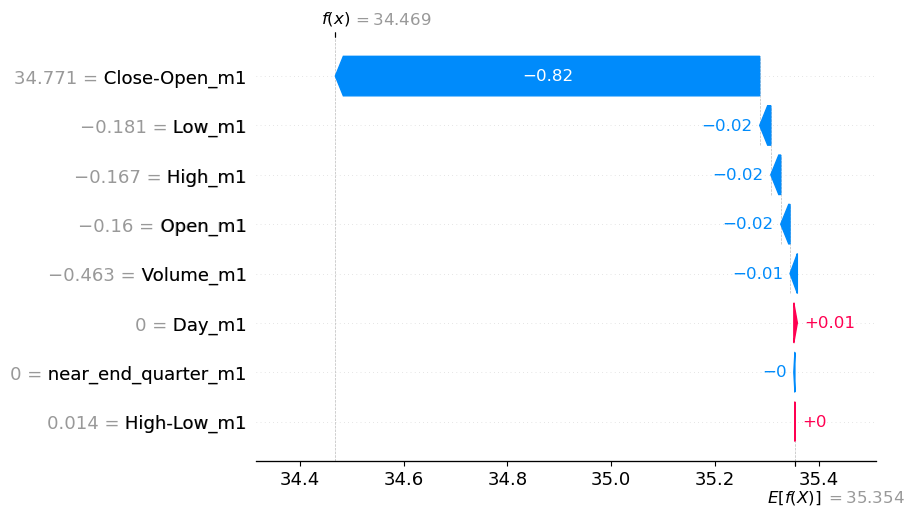

In [9]:
from sklearn.svm import SVR

parameters_mdl = {'C':[.25, .5, .75, 1, 1.25, 1.5, 1.75, 2], 'epsilon':[.01, .02, .03]}
mdl_r_svro = SVR()
n_for=[1,2,3,4,5,6,7,8,9,10,11,12,13,14]
n_aft=[1,5]
svrResults = modeldriverCV(mdl_r_svro, n_aft, n_for,f, st, sn, parameters_mdl,SVR=True)

Run time 3.993037462234497s
Ridge()
.values =
array([[-1.07697453e+00, -1.07792106e+00, -8.94049894e-01, ...,
        -8.30275503e+00, -4.46281237e-03,  2.16439104e-05],
       [-1.04659297e+00, -1.04787886e+00, -8.61054328e-01, ...,
        -7.88184458e+00, -4.46281237e-03,  3.30842631e-04],
       [-1.03535863e+00, -1.03677001e+00, -8.64861509e-01, ...,
        -7.87890468e+00, -4.46281237e-03,  6.40041351e-04],
       ...,
       [ 2.17385241e+00,  2.14888219e+00,  1.74579360e+00, ...,
         1.62246143e+01, -4.46281237e-03, -5.96753531e-04],
       [ 2.14259164e+00,  2.11109277e+00,  1.73913897e+00, ...,
         1.59540701e+01, -4.46281237e-03, -2.87554810e-04],
       [ 2.14454544e+00,  2.13079891e+00,  1.74511942e+00, ...,
         1.61254957e+01, -4.46281237e-03,  2.16439104e-05]])

.base_values =
array([[35.34473155],
       [35.34473155],
       [35.34473155],
       ...,
       [35.34473155],
       [35.34473155],
       [35.34473155]])

.data =
array([[-1.67946379, -1.686

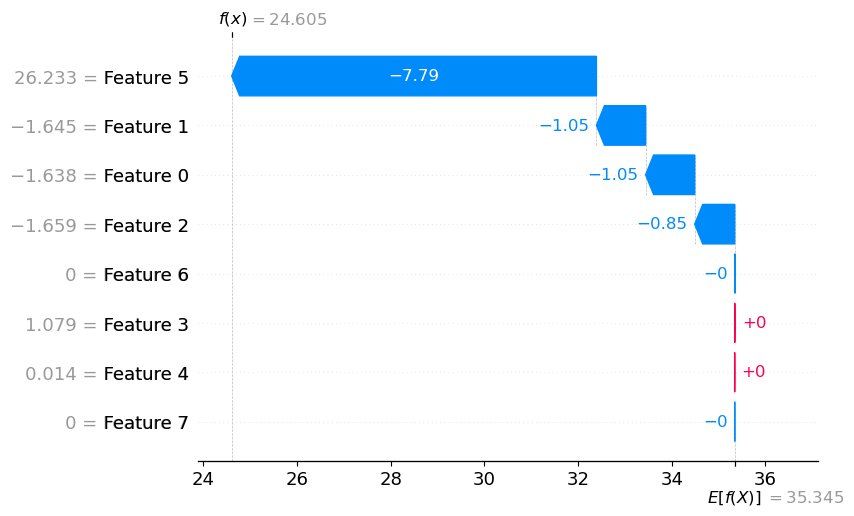

Run time 15.755681037902832s
Ridge()
.values =
array([[-1.07697453e+00, -1.07792106e+00, -8.94049894e-01, ...,
        -8.30275503e+00, -4.46281237e-03,  2.16439104e-05],
       [-1.04659297e+00, -1.04787886e+00, -8.61054328e-01, ...,
        -7.88184458e+00, -4.46281237e-03,  3.30842631e-04],
       [-1.03535863e+00, -1.03677001e+00, -8.64861509e-01, ...,
        -7.87890468e+00, -4.46281237e-03,  6.40041351e-04],
       ...,
       [ 2.17385241e+00,  2.14888219e+00,  1.74579360e+00, ...,
         1.62246143e+01, -4.46281237e-03, -5.96753531e-04],
       [ 2.14259164e+00,  2.11109277e+00,  1.73913897e+00, ...,
         1.59540701e+01, -4.46281237e-03, -2.87554810e-04],
       [ 2.14454544e+00,  2.13079891e+00,  1.74511942e+00, ...,
         1.61254957e+01, -4.46281237e-03,  2.16439104e-05]])

.base_values =
array([[35.34473155],
       [35.34473155],
       [35.34473155],
       ...,
       [35.34473155],
       [35.34473155],
       [35.34473155]])

.data =
array([[-1.67946379, -1.68

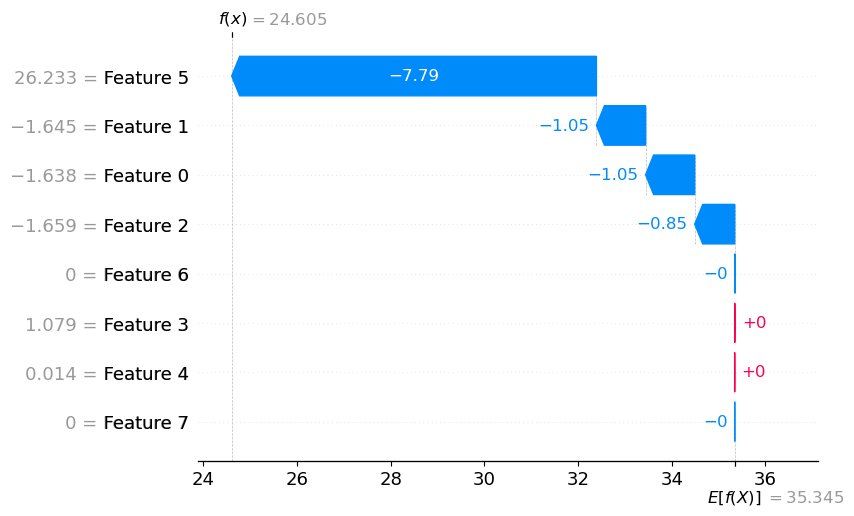

In [13]:
from sklearn.linear_model import Ridge

# mdl_r = Ridge(alpha=0.01)
# y_train, y_test, score_train, score_test = modeldriver(mdl_r, 5, 1, f, st, sn)

# # plt.scatter(y_train,T_train.iloc[5:])

# plt.plot(range(0,len(T_train.iloc[5:])),T_train.iloc[5:])
# plt.scatter(range(0,len(T_train.iloc[5:])),y_train,c='r')

parameters_mdl = {'alpha':np.linspace(.001,10)}

mdl_r_grido = Ridge()
n_for=[1,2,3,4,5,6,7,8,9,10,11,12,13,14]
n_aft=[1,5]
ridgeResults = modeldriverCV(mdl_r_grido, n_aft, n_for, f, st, sn, parameters_mdl,SVR=False);

Run time 7.111647129058838s
Lasso()
.values =
array([[ 8.88178420e-16,  5.55111512e-16,  5.55111512e-16, ...,
        -1.14357877e+01,  9.99200722e-16,  0.00000000e+00],
       [ 2.66453526e-15,  3.33066907e-16,  3.33066907e-16, ...,
        -1.08560473e+01,  7.77156117e-16,  0.00000000e+00],
       [ 4.44089210e-15,  1.88737914e-15,  1.88737914e-15, ...,
        -1.08519980e+01,  8.88178420e-16,  0.00000000e+00],
       ...,
       [ 8.88178420e-16, -7.77156117e-16,  1.88737914e-15, ...,
         2.23469490e+01,  6.66133815e-16,  0.00000000e+00],
       [-4.44089210e-15, -2.10942375e-15,  5.55111512e-16, ...,
         2.19743154e+01,  0.00000000e+00,  0.00000000e+00],
       [ 8.88178420e-16,  2.33146835e-15, -1.22124533e-15, ...,
         2.22104282e+01, -1.11022302e-16,  0.00000000e+00]])

.base_values =
array([35.33984258, 35.33984258, 35.33984258, ..., 35.33984258,
       35.33984258, 35.33984258])

.data =
array([[-1.67946379, -1.68622812, -1.73199612, ..., 25.62546379,
         

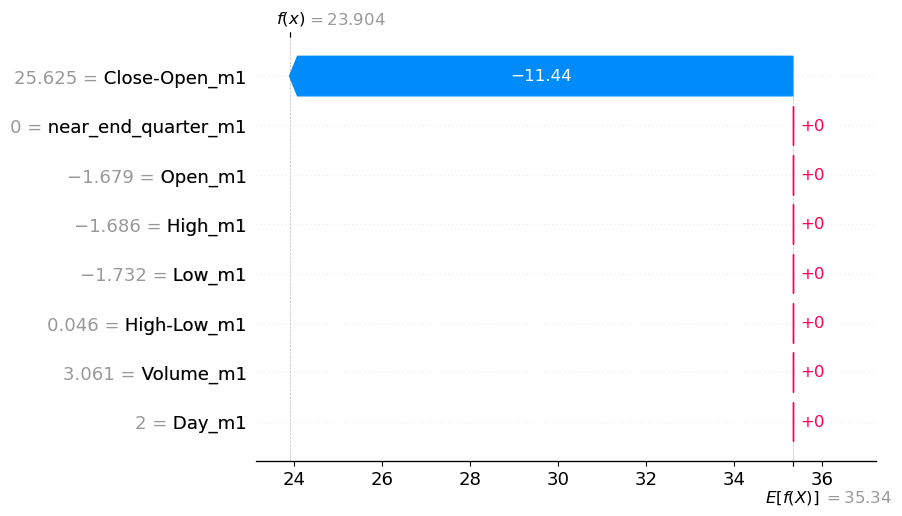

Run time 32.16586995124817s
Lasso()
.values =
array([[ 8.88178420e-16,  5.55111512e-16,  5.55111512e-16, ...,
        -1.14357877e+01,  9.99200722e-16,  0.00000000e+00],
       [ 2.66453526e-15,  3.33066907e-16,  3.33066907e-16, ...,
        -1.08560473e+01,  7.77156117e-16,  0.00000000e+00],
       [ 4.44089210e-15,  1.88737914e-15,  1.88737914e-15, ...,
        -1.08519980e+01,  8.88178420e-16,  0.00000000e+00],
       ...,
       [ 8.88178420e-16, -7.77156117e-16,  1.88737914e-15, ...,
         2.23469490e+01,  6.66133815e-16,  0.00000000e+00],
       [-4.44089210e-15, -2.10942375e-15,  5.55111512e-16, ...,
         2.19743154e+01,  0.00000000e+00,  0.00000000e+00],
       [ 8.88178420e-16,  2.33146835e-15, -1.22124533e-15, ...,
         2.22104282e+01, -1.11022302e-16,  0.00000000e+00]])

.base_values =
array([35.33984258, 35.33984258, 35.33984258, ..., 35.33984258,
       35.33984258, 35.33984258])

.data =
array([[-1.67946379, -1.68622812, -1.73199612, ..., 25.62546379,
         

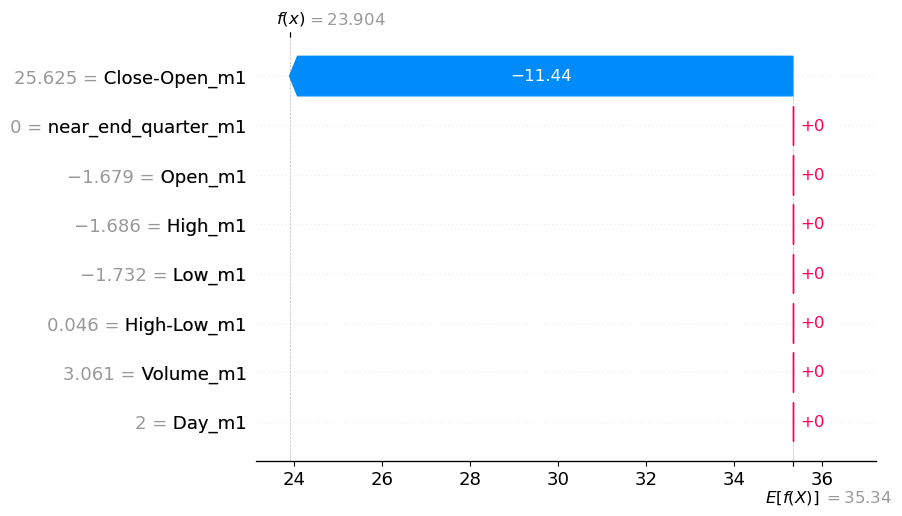

In [12]:
from sklearn.linear_model import Lasso

# mdl_l = Lasso(alpha=0.01)

# y_train, y_test, score_train, score_test = modeldriver(mdl_l, 5, f, st, sn)

# plt.plot(range(0,len(T_train.iloc[5:])),T_train.iloc[5:])
# plt.scatter(range(0,len(T_train.iloc[5:])),y_train,c='r')

parameters_mdl = {'alpha':np.linspace(.01,.09)}
mdl_r_grido = Lasso()
n_for=[1,2,3,4,5,6,7,8,9,10,11,12,13,14]
n_aft=[1,5]
lassoResults = modeldriverCV(mdl_r_grido, n_aft, n_for,f, st, sn, parameters_mdl,SVR=False)

In [ ]:
print(lassoResults)

In [ ]:
pickleBucket(sn, (ridgeResults, lassoResults, svrResults))

In [ ]:
from sklearn.linear_model import (Ridge,
                                  Lasso,
                                )

from sklearn.svm import (SVR,
                         )



n_days_back = 5
n_days_for = 5

print('Ridge')
mdl_r = Ridge(alpha=1)

y_train, y_test, data_out = modeldriver(mdl_r, n_days_back, n_days_for, f, st, sn)

print('Lasso')
mdl_l = Lasso(alpha=0.01)

y_train, y_test, data_out = modeldriver(mdl_l, n_days_back, n_days_for, f, st, sn)




In [ ]:
print(np.shape(y_test))

In [ ]:
plotlen = 1000

x = range(0,plotlen)

print(np.shape(y_test))
for ii in range(0,np.shape(y_test)[1]):
    y_true = data_out['T_test'].iloc[0:plotlen,ii]
    y_test_plt = y_test.iloc[0:plotlen,ii]
    plt.figure(figsize=(9,9))
    plt.scatter(y_test_plt,y_true,label='true')
    plt.title('day '+ str(ii) + ' prediction')